# M2 | Exploration Notebook

In this notebook, you will do a first exploration of the data set that you will use for your project. One part of this exploration is guided, i.e. we will ask you to solve specific questions (task 1-3). The other part is open, i.e. we will ask you to come up with your own exploration ideas (task 4). 


## Brief overview of Dataset
Dataset is a mathematics learning program developed with neuroscientists and computer scientists from ETH Zurich. It promotes the development and interaction of the different areas of the brain that are responsible for processing numbers and quantities and solving mathematical tasks. Dataset can be used from 1st grade to high school. Children with dyscalculia also benefit in the long term and overcome their arithmetic weakness.


For the guided part of the exploration we will focus on the three main tables:
* ***users***: meta information about users (i.e. total time spent learning with Dataset, geographic location).
* ***events***: events done by the users in the platform (i.e. playing a game, selecting a new animal in the zoo simulation).
* ***subtasks***: sub-tasks with answer attempts solved by users, primarily in the context of game events.

### Users
* **user_id**: unique identifier of user in database.
* **learning_time_ms**: total learning time in milliseconds per user, totaled over all events. This is calculated by subtracting non-learning time (i.e. if the user is idle for more than one minute).
* **start**: timestamp of initial login.
* **end**: timestamp of last log-off.
* **logged_in_time_ms**: total time between login and log-off, in milliseconds. This will always be larger than learning_time_ms.
* **language**: code for language the user is using programme in (i.e. *fr* for French, *de* for german).
* **country**: code for the country the user is using programme from (i.e. *CH* for Switzerland).

### Events
* **event_id**: unique identifier of event in database.
* **user_id**: user who peformed the event.
* **type**: type of event (task, help, game_start_pause, training_selector, shop, attention_booster, attention_booster_over).
* **mode**: only valid for events of type 'task', representing type of game play (normal, end_of_nr: end of number range, free_training, repetition, favorite, practice).
* **game_name**: name of the game the user is playing. Programme has 29 games.
* **learning_time_ms**: total learning time over a single game (event). To see aggregated learning time, examine learning_time_ms in the users table.
* **number_range**: the number range of the exercise (0-10, 0-20, ... 0-1000). The larger the number range, the more difficult the exercise variation.
* **start**: start timestamp of the event.
* **end**: end timestamp of the event.
* **skill_id**: skill number that this game (event) corresponds to.

### Subtasks
*There are many columns in subtasks corresponding to fields present for specific games in programme. The fields discussed below are present for the majority of subtasks.*

* **subtask_id**: unique identifier of the subtask in the database.
* **event_id**: unique identifier of event in database.
* **user_id**: user who peformed the event.
* **answer**: the user's answer to the subtask.
* **correct**: `True` if user obtained the correct value in their answer attempt.
* **correctAnswerObject**: the correct answer to the question.
* **hasProperResult**: `True` if this is a question that can be answered by a student. `False` if it corresponds to the SecretNumber game tasks, which consists of counting attempts.
* **range**: number_range for the task (i.e. 0-20 described as R20).
* **subtask_finished_timestamp**: ending timestamp for this subtask (within a specific event).
* **type**: type of subtask event like ConciseEquationTaskDescription, ConciseOrderingTaskDescription (mostly corresponding to individual games, as detailed in the *Subtask Representations* document below).

### Useful Metadata Files
- [Subtask Representations](https://drive.google.com/file/d/1C7bKfHDdKnDzr9-EqWniYoR35ro2QuBd/view?usp=sharing)
- [Number Representations](https://docs.google.com/document/d/1iD60mydGXjB-6HBQakAKI_GGfQaBBQkWcg5eQiAch_A/edit?usp=sharing)
- [Skill map](https://drive.google.com/file/d/1yJTosk1RV1qzHb-AG_-FLdjlphBsYzoq/view?usp=sharing) representing the relationships between exercises in Dataset. If you would like to dive deeper into the skill network (programatically), you can use this [.dot file](https://docs.google.com/document/d/1XDPkq7LaAQ3-lAhAvDTLXuiq5u8EKJME/edit?usp=share_link&ouid=104052806655845468726&rtpof=true&sd=true) representing the graph and the corresponding [labels](https://drive.google.com/file/d/1Pkbiz-_bzK80q2l3mkBS_K4wU9sSCY-R/view?usp=sharing).

In [2]:
#Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from textwrap import wrap
from fitter import Fitter
from datetime import timezone
import datetime

In [3]:
# Import the tables of the data set as dataframes.
DATA_DIR = 'new_data_1000' #You many change the directory

users = pd.read_csv('{}/small_users.csv'.format(DATA_DIR), index_col=0)
events = pd.read_csv('{}/small_events.csv'.format(DATA_DIR), index_col=0)
subtasks = pd.read_csv('{}/small_subtasks.csv'.format(DATA_DIR), index_col=0)

In [4]:
users.head(5)
print(len(events))
print(len(subtasks))

34094
55047


In [163]:
events.head(5)

,user_id,mode,game_name,learning_time_ms,number_range,start,end,skill_id,type
event_id,,,,,,,,,
0,1,NORMAL,Subitizing,8835.0,R10,2022-11-02T08:39:12.355Z,2022-11-02T08:39:25.130Z,1.0,task
1,1,NORMAL,Conversion,21167.0,R10,2022-11-11T10:26:27.893Z,2022-11-11T10:26:49.260Z,4.0,task
2,1,NORMAL,Conversion,11182.0,R10,2022-11-18T10:34:01.044Z,2022-11-18T10:34:12.423Z,7.0,task
3,1,NORMAL,Landing,6823.0,R10,2022-11-25T10:32:43.428Z,2022-11-25T10:32:56.986Z,19.0,task
4,1,END_OF_NR,Conversion,9107.0,R10,2022-12-02T10:44:40.555Z,2022-12-02T10:44:49.874Z,7.0,task


In [164]:
subtasks.head(5)

,event_id,user_id,aim,answer,answerMode,availableNumbers,correct,correctAnswerObject,correctNumber,destination,...,startPosition,subtask_finished_timestamp,target,timeoutInSeconds,timeoutInSteps,type,upperBound,divisor,orderIndependent,step
subtask_id,,,,,,,,,,,,,,,,,,,,,
0,0,1,NaN,4,NaN,NaN,True,4,4.0,NaN,...,NaN,2022-11-02T08:39:24.930Z,NaN,NaN,NaN,ConciseSubitizingTaskDescription,NaN,NaN,NaN,NaN
1,0,1,NaN,1,NaN,NaN,True,NaN,NaN,NaN,...,NaN,2022-11-02T08:39:24.930Z,NaN,0.0,2.0,ConciseTimeoutDescription,NaN,NaN,NaN,NaN
2,1,1,NaN,3,NaN,NaN,True,3,NaN,ARABIC,...,NaN,2022-11-11T10:26:49.007Z,NaN,NaN,NaN,ConciseConversionTaskDescription,NaN,NaN,NaN,NaN
3,2,1,NaN,5,NaN,NaN,True,5,NaN,EXPLODED_BEAM,...,NaN,2022-11-18T10:34:12.191Z,NaN,NaN,NaN,ConciseConversionTaskDescription,NaN,NaN,NaN,NaN
4,3,1,3.0,"{'a': 2, 'b': 2.0402703}",NaN,NaN,False,"{'a': 3, 'b': 3.0}",NaN,NaN,...,0.5,2022-11-25T10:32:56.805Z,NaN,NaN,NaN,ConciseLandingTaskDescription,3.5,NaN,NaN,NaN


## Task 1: Simple Statistics

In this task you are asked to do a first coarse exploration of the data set, using simple statistics and visualizations.

#### a) How many distinct participants do we have in the data set?


In [165]:
print(f"We have {len(users)} users")

We have 1000 users


#### b) How many games were played per user? Please provide a visualization and discuss the distribution.

In [166]:
def get_game_stats():
    all_games_stats = []
    unique_users = events["user_id"].unique()
    for user in unique_users:
        how_many_games = events.loc[events['user_id'] == user]
        all_games_stats.append(len(how_many_games))
    return all_games_stats

def display_stats(stats = get_game_stats()):
    plt.hist(stats, bins = 200, color = "skyblue")
    plt.title("How many games were played per user")
    plt.xlabel("users")
    plt.ylabel("games")
    return plt

def get_fit_dist(data):
    f = Fitter(data,
           distributions=['gamma',
                          'lognorm',
                          "beta",
                          "burr",
                          "norm"])
    f.fit()
    return f.summary(Nbest=1, method='sumsquare_error')

<module 'matplotlib.pyplot' from 'c:\\Users\\ewa.miazga\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages\\matplotlib\\pyplot.py'>

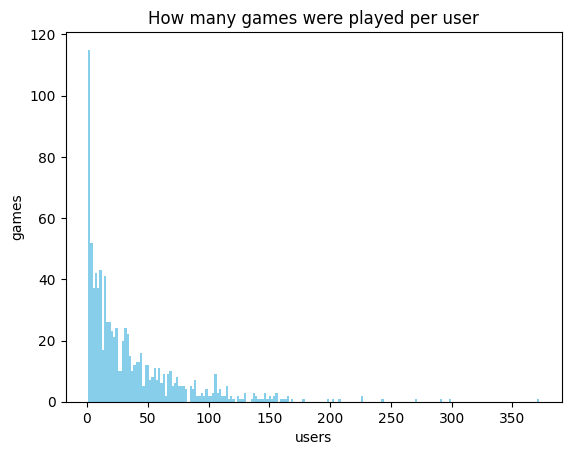

In [167]:
display_stats()

Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00,  6.92it/s]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
burr,0.000182,1594.719293,-14271.578155,inf,0.202936,6.542526e-34


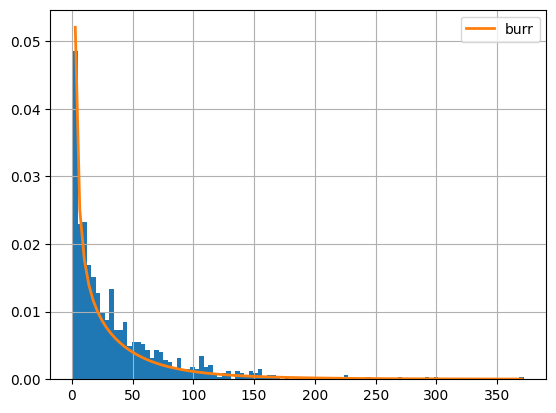

In [168]:
get_fit_dist(get_game_stats())

**Interpretation**

We could point two possible approaches to this problem:
- Count how many times indivudal user have played games.
- Count how many unqiue games were played by individual user.
I have choosen the first approach, because I belive it better fits to this problem.

There is really small part of users who played more than 100 times. Next we can assume that most of games users played at least 10 times.
The decrease of values in graph is dynamical at first and after dropping below 50 games played by user we can notice that it is started to be softer. So There is not much users who played lesser than 5 times.

We can conclude from this observation that the Burr distribution is the one that estimates data's histogram most accurately. It can be proven by using the fitter package which calculates the sum squared error of few most common distributions and histogram.

#### c) What are the 10 most popular games played (events)? Please provide visualizations of the frequency of the top 10 games.

Hint: See `game_name` in table `events`.

In [169]:
def get_most_popular_games():
    all_games_stats = []
    unique_games = events['game_name'].unique()
    for game in unique_games:
        how_many_games = events[events['game_name'] == game]
        how_many_users = len(how_many_games['user_id'].unique())
        all_games_stats.append((how_many_users, game))
    all_games_stats.sort(reverse=True)

    how_many = [i[0] for i in all_games_stats[:10]]
    game_names = [i[1] for i in all_games_stats[:10]]
    return how_many, game_names

def display_most_popular_games(how_many, game_names):
    game_names = ['\n'.join(wrap(l, 15)) for l in game_names]
    plt.xticks(rotation=80)
    plt.xlabel("name of games")
    plt.ylabel("how many users play this game")
    plt.title("10 most popular games")
    plt.bar(game_names, how_many, color='blueviolet')
    return plt

<module 'matplotlib.pyplot' from 'c:\\Users\\ewa.miazga\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages\\matplotlib\\pyplot.py'>

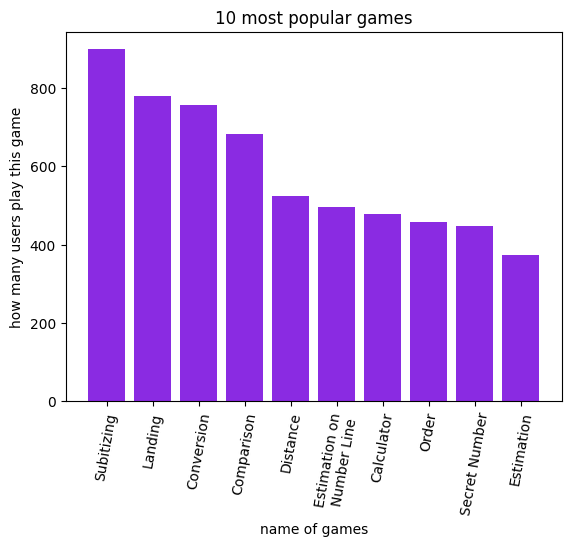

In [170]:
how_many, game_names = get_most_popular_games()
display_most_popular_games(how_many, game_names)

**interpretation**

Here also we can interpretate this task in at least two ways:
- How many times the game was played in total.
- How many users play particular game.

I am decide to create a bar plot for second interpretation. However it may be more detailed and accurate if we create weighted graph for this approach. For instance, if one player played a game one time weight = 1.0, but if he played the game 20 times, weight should be scaled by regular_factor (rf), so as a result we included the contribution of frequency of playing the game.

Analysing our plot we can conclude that Subitizing is the most popular game among the users. It could be connected with the low skill_id for this game, which indicates that the game is not hard to play. So players are more likely to come back to that one. It also could be reason why twice of users playing the 10th most common game which is Estimation, decide to play in Subitizing.

## Task 2: Static Analysis

In this second task, you will do a univariate an multivariate exploration of some aggregated features.

#### a) Build a data frame containing one row per user:

``[user_id, ui_locale, num_events, num_games, percentage_correct, total_not_learning_time_ms]``


The features are defined as follows:

- **ui_locale**: geographic region the student is from

- **num_events**: total number of events of the student  

- **num_games**: total number of unique games played by the student

- **percentage_correct**: number of correct answers/total number of answers (hint: see `correct` in subtask table).

- **total_not_learning_time_ms**: total amount of ms not spent actively learning

In [171]:
def create_dataframe():
    df = pd.DataFrame(columns = ['ui_locale', 'num_events', 'num_games', 'percentage_correct', 'total_not_learning_time_ms'])
    df.index.name = 'user_id'
    for index, user in users.iterrows():
        user_id = index
        language = user['language']
        country = user['country']
        ui_locale = str(language) + ", " + str(country) 

        user_events = events.loc[events['user_id'] == user_id]
        num_events = len(user_events)
        num_games = len(user_events['game_name'].unique())

        how_many_answer = subtasks.loc[subtasks['user_id'] == user_id]
        how_many_correct = how_many_answer.loc[how_many_answer['correct'] == True]
        percentage_correct = (len(how_many_correct) / len(how_many_answer)) * 100 if len(how_many_answer) else 0

        logged = user['logged_in_time_ms']
        learning = user['learning_time_ms']
        total_not_learning_time_ms = logged - learning
        df.loc[user_id] = [ui_locale, num_events, num_games, percentage_correct, total_not_learning_time_ms]
    return df
    

In [172]:
df = create_dataframe()
df

,ui_locale,num_events,num_games,percentage_correct,total_not_learning_time_ms
user_id,,,,,
1,"de, CH",12,6,78.571429,8118630
2,"nl, NL",56,7,68.115942,69152923
3,"de, DE",10,4,66.666667,8639452
4,"de, CH",2,2,66.666667,3147347
5,"de, CH",14,7,76.470588,8099362
...,...,...,...,...,...
996,"de, CH",6,3,63.636364,2866018
997,"de, DE",12,7,89.473684,3265984
998,"de, CH",22,9,76.666667,11551330


b) Perform a univariate analysis (including descriptive statistics and visualizations) for the five features (`ui_locale, num_events, num_games, percentage_correct, total_not_learning_time_ms`) of your dataframe. Please check the lecture slides regarding information on how to perform a univariate analysis for categorical and numerical features. Discuss your results: how are the features distributed? Are there any anomalities?

In [173]:
#types in my dataframe
df['ui_locale'] = pd.Categorical(df.ui_locale)
df.dtypes

ui_locale                     category
num_events                       int64
num_games                        int64
percentage_correct             float64
total_not_learning_time_ms       int64
dtype: object

In [174]:
# Your code for univariate analysis here

#Descriptive Statistics:
def get_feature_stats(df):
    stats = df.describe(include= 'all')
    stats = stats.loc[['mean', 'std', '50%', 'unique', 'top', 'freq']]
    percentage = df.isnull().sum(axis = 0)*100 / len(df)
    stats.loc['missing_values'] = np.array(percentage)
    return stats

In [175]:
stats = get_feature_stats(df)
stats

,ui_locale,num_events,num_games,percentage_correct,total_not_learning_time_ms
mean,NaN,34.094000,7.196000,69.563254,2.470131e+07
std,NaN,42.475585,4.738358,26.276221,5.167130e+07
50%,NaN,19.000000,7.000000,77.777778,1.070713e+07
unique,18,NaN,NaN,NaN,NaN
top,"de, CH",NaN,NaN,NaN,NaN
freq,444,NaN,NaN,NaN,NaN
missing_values,0.0,0.000000,0.000000,0.000000,0.000000e+00


In [176]:
#Visualization:
def plot_features(df, row, col):
    """
    Plots all features individually in the same figure
    
    Parameters
    ----------
    df : DataFrame
         Containing all data
         
    Hint
    ------
    To have multiple plots in a single figure see pyplot.figure

    """    
    df = df.copy()
    
    def plot_features(df, title, row, col):
        continuous_cols = list(df._get_numeric_data().columns)
        time_cols = [col for col in df.columns if df[col].dtype == 'timedelta64[ns]']
        categorical_cols = list(set(df.columns) - set(continuous_cols) - set(time_cols))
        fig, axes = plt.subplots(row, col, figsize=(15, 10))
        for i, col in enumerate(df.columns):
            ax = axes[i // 3, i % 3]
            data = df[~df[col].isna()]
            if col in continuous_cols:
                sns.histplot(data=data[col], bins=50, ax=ax) #Filter out nan values in the features
            elif col in categorical_cols:
                sns.countplot(data=data, x=col, ax=ax)
                ax.tick_params(axis='x', rotation=80)
            elif col in time_cols:
                df[f'{col}'].astype('timedelta64[D]').plot.hist(ax=ax, bins=50, edgecolor='black', color='skyblue')
                ax.tick_params(axis='x', rotation=80)
                ax.set_xlabel(df.columns[i] + "_days")
            else:
                print(col)
        fig.suptitle(title)
        fig.tight_layout()
    
    
    plot_features(df, "Raw data", row, col)
    plt.show()
    return plt

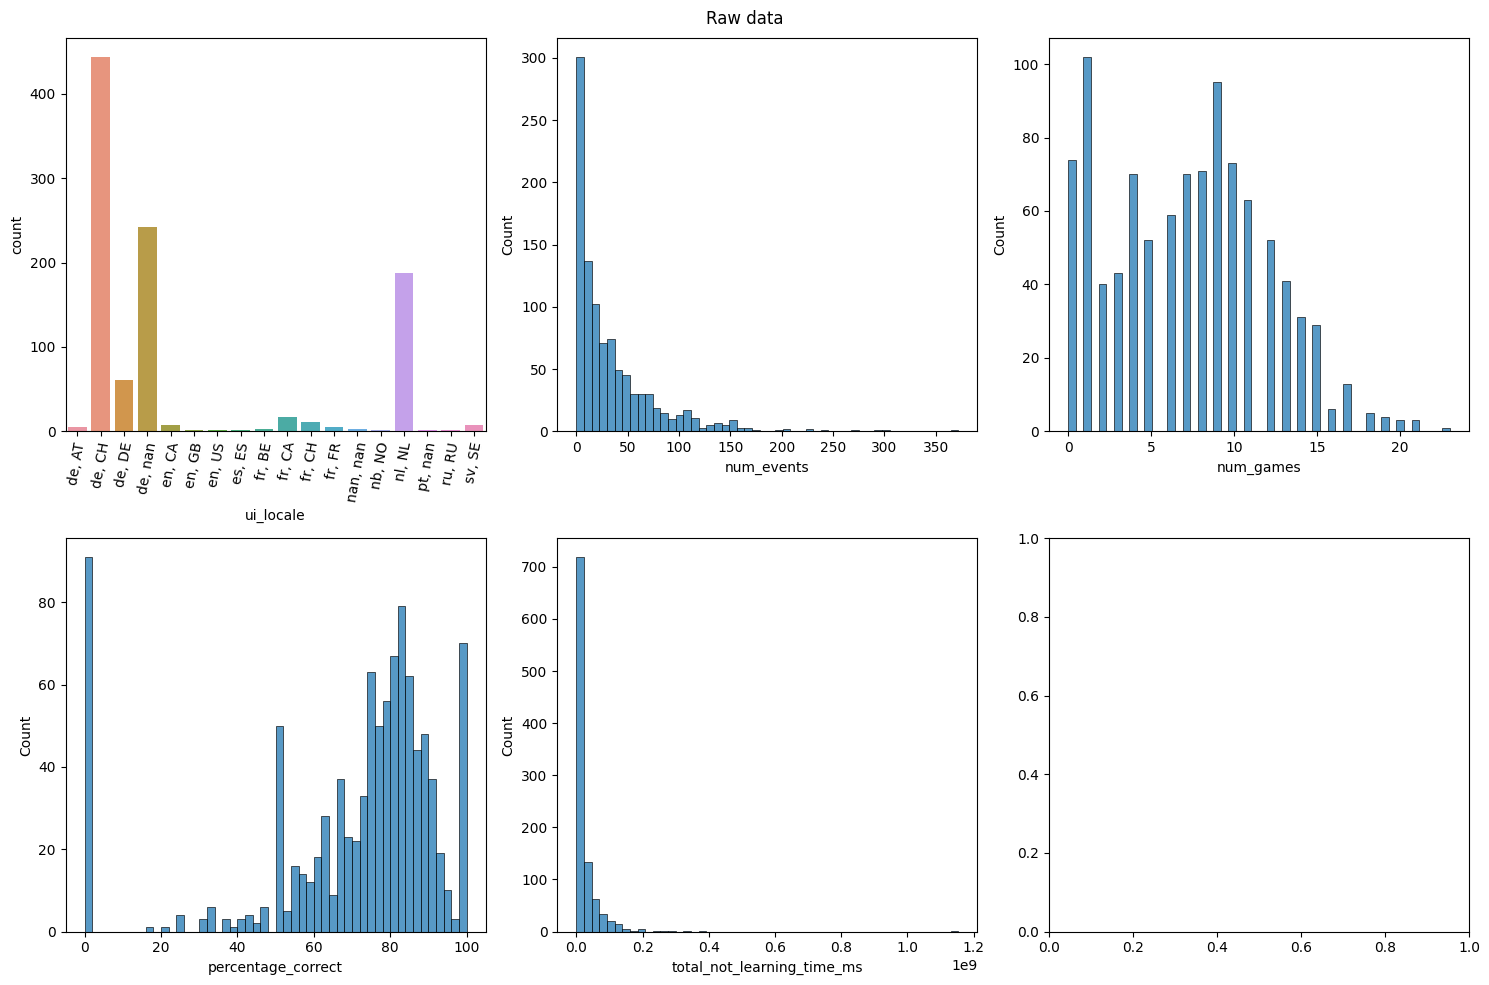

<module 'matplotlib.pyplot' from 'c:\\Users\\ewa.miazga\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [177]:
plot_features(df, 2, 3)  

['num_events', 'num_games', 'percentage_correct', 'total_not_learning_time_ms']
num_games


Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00,  7.22it/s]


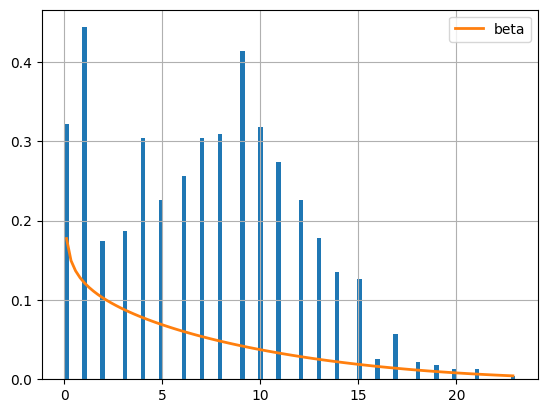

In [178]:
continuous_cols = list(df._get_numeric_data().columns)
print(continuous_cols)

def get_fitter_predictions(df, idx):
    for i, col in enumerate(continuous_cols):
        if i == idx:
            print(col)
            data = df[~df[col].isna()]
            get_fit_dist(data[col])

get_fitter_predictions(df, 1)

**Your discussion/interpretation goes here**

We can observe that: 
- **ui_locale**: 'de, CH' the most popular region in dataset, in the descriptive satistics we can find out there are 444 records with that value in  ui_locale column, so they are almost half of all the records.
- **num_events**: Distribution is right skwed it could be lognormal or beta. Fitter predicts the beta distribution.
- **num_games**: This distribution is hard to classify, it is a little bit right skewed. for 0 and 1 game values are very high and then it increases gradually until 9 games, where it also starts decreasing gradually. 
- **percentage_correct**: Distribution is left skwed, it may be gamma, but fitter points that this is probably the Burr distribution. We can also find the abnormalities in this plot, because there is a big group with 0% correctly answered questions.
- **total_not_learning_time_ms**: Distribution looks like lognormal, which is in accordance with the predictions of fitter.

c) Come up with two additional features on your own and add them to the dataframe. Please provide an explanation/description of your features as well as an argument/hypothesis of why you think these features are interesting to explore.

In [179]:
# Your code for computing the features and adding them to the df goes here

def add_features(df):
    now = datetime.datetime.now(timezone.utc)

    users['end'] = pd.to_datetime(users['end'])
    users['start'] = pd.to_datetime(users['start'])

    last_logs = []
    acc_lifetimes = []
    for index, user in users.iterrows():
        since_last_log = now - user['end']
        last_logs.append(since_last_log)

        account_lifetime = user['end'] - user['start']
        acc_lifetimes.append(account_lifetime)
    df['since_last_logout'] = last_logs
    df['account_lifetime'] = acc_lifetimes
    return df

In [180]:
df = add_features(df)
df

,ui_locale,num_events,num_games,percentage_correct,total_not_learning_time_ms,since_last_logout,account_lifetime
user_id,,,,,,,
1,"de, CH",12,6,78.571429,8118630,35 days 09:03:42.875326,99 days 02:30:06.050000
2,"nl, NL",56,7,68.115942,69152923,35 days 11:32:30.782326,155 days 00:45:35.827000
3,"de, DE",10,4,66.666667,8639452,427 days 07:57:35.909326,108 days 04:28:17.759000
4,"de, CH",2,2,66.666667,3147347,895 days 10:51:16.676326,324 days 21:02:13.074000
5,"de, CH",14,7,76.470588,8099362,199 days 04:19:34.387326,125 days 04:13:26.973000
...,...,...,...,...,...,...,...
996,"de, CH",6,3,63.636364,2866018,114 days 11:51:38.171326,60 days 19:52:52.751000
997,"de, DE",12,7,89.473684,3265984,640 days 08:48:47.440326,59 days 04:05:33.057000
998,"de, CH",22,9,76.666667,11551330,799 days 05:41:35.941326,146 days 02:08:50.961000


**Your feature descriptions and arguments**

I decide to add columns:
1. **since_last_login**: to which describes for how long the account is inactive. 
2. **account_lifetime**: which describes the time between last logout and first login to the account.

I decide to choose this two features because I wanted to compare for how long the account exists with the time of last login to the application.

**Hypotheses**
- Most of accounts are active.

d) Perform a univariate analysis of your features (including descriptive statistics and visualization). What can you observe? Do the results confirm your hypotheses?

In [181]:
# Your code for univariate analysis goes here

#Descriptive Statistics:
get_feature_stats(df)

,ui_locale,num_events,num_games,percentage_correct,total_not_learning_time_ms,since_last_logout,account_lifetime
mean,NaN,34.094000,7.196000,69.563254,2.470131e+07,834 days 16:37:14.251083008,272 days 22:11:33.038741
std,NaN,42.475585,4.738358,26.276221,5.167130e+07,725 days 10:49:33.800663200,312 days 19:58:27.392819596
50%,NaN,19.000000,7.000000,77.777778,1.070713e+07,668 days 19:23:10.240326,162 days 13:22:38.282000
unique,18,NaN,NaN,NaN,NaN,NaN,NaN
top,"de, CH",NaN,NaN,NaN,NaN,NaN,NaN
freq,444,NaN,NaN,NaN,NaN,NaN,NaN
missing_values,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.0


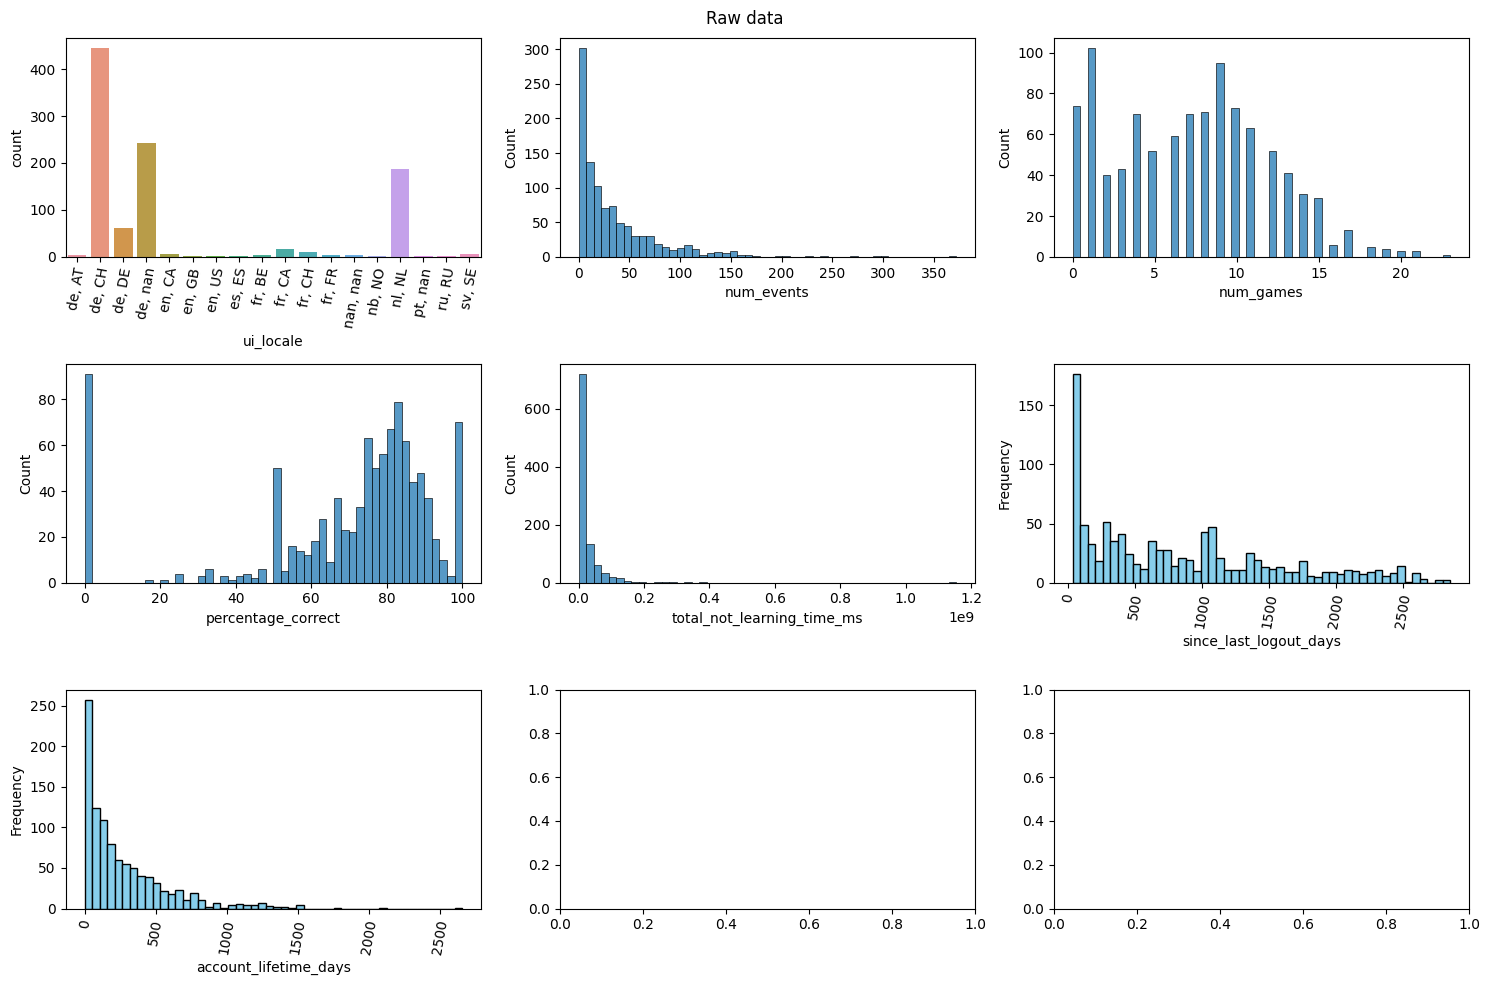

<module 'matplotlib.pyplot' from 'c:\\Users\\ewa.miazga\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [182]:
#Visualization:
plot_features(df, 3, 3)

**Your discussion/interpretation goes here**

We can observe that:
1. **since_last_out_days**: Three times as many accounts were not active in last 50 days than in last 100 days. The distribution is very roughly, so it is hard to assign particular distribution to it. 
2. **account_life_time_days**: Most of accounts do not exist for longer than 250 days. Twice as much accounts which are exisiting for up to 100 days exist for on longer than 50 days. We can assume that there is not much accounts which are active for more than 1500 days. Distribution looks like beta distribution.

Thanks to this analyse I can assume that average account exist for not longer than year and the average time since last logout from app is equal to 834 days (more than 2 years).
So many of accounts seem to be abandoned. My hypothesis was wrong, the result seems to be the opposite of my assumptions.

But to be able to derive information that allow me to answer the hypotesis, I have to perform multivariate analysis. I will do it in next step. 

In [183]:
def convert_time_to_num(df):
    time_cols = [col for col in df.columns if df[col].dtype == 'timedelta64[ns]']
    for col in time_cols:
        df[f'{col}'] = df[f'{col}'].dt.days

convert_time_to_num(df)

e) Perform a multivariate analysis for two pairs of features of your choice. Please provide a metric and a visualization for both pairs. Please discuss: why did you choose these two pairs? What was your hypothesis? Do the results confirm your hypothesis?

C:\Users\ewa.miazga\AppData\Local\Temp\ipykernel_17532\3397012682.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = np.round(df.corr(method='pearson'), 3)


<AxesSubplot: title={'center': 'Correlation between variables'}>

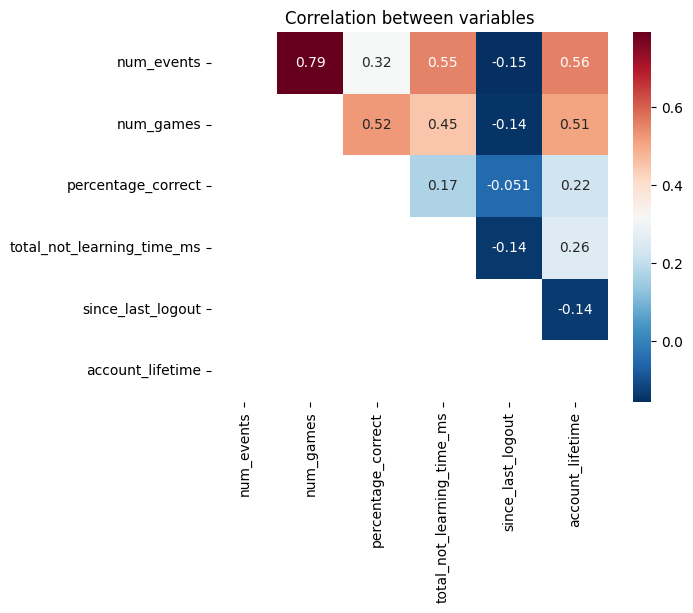

In [184]:
# Your code for multivariate analysis goes here

#Multivariate analysis for all columns of dataframe
import seaborn as sns
def plot_correlation(df):
    corr = np.round(df.corr(method='pearson'), 3)
    mask = np.tril(corr)
    ax = plt.axes()
    heatmap = sns.heatmap(corr, annot=True, mask=mask, cmap='RdBu_r')
    ax.set_title('Correlation between variables')
    return heatmap

plot_correlation(df)

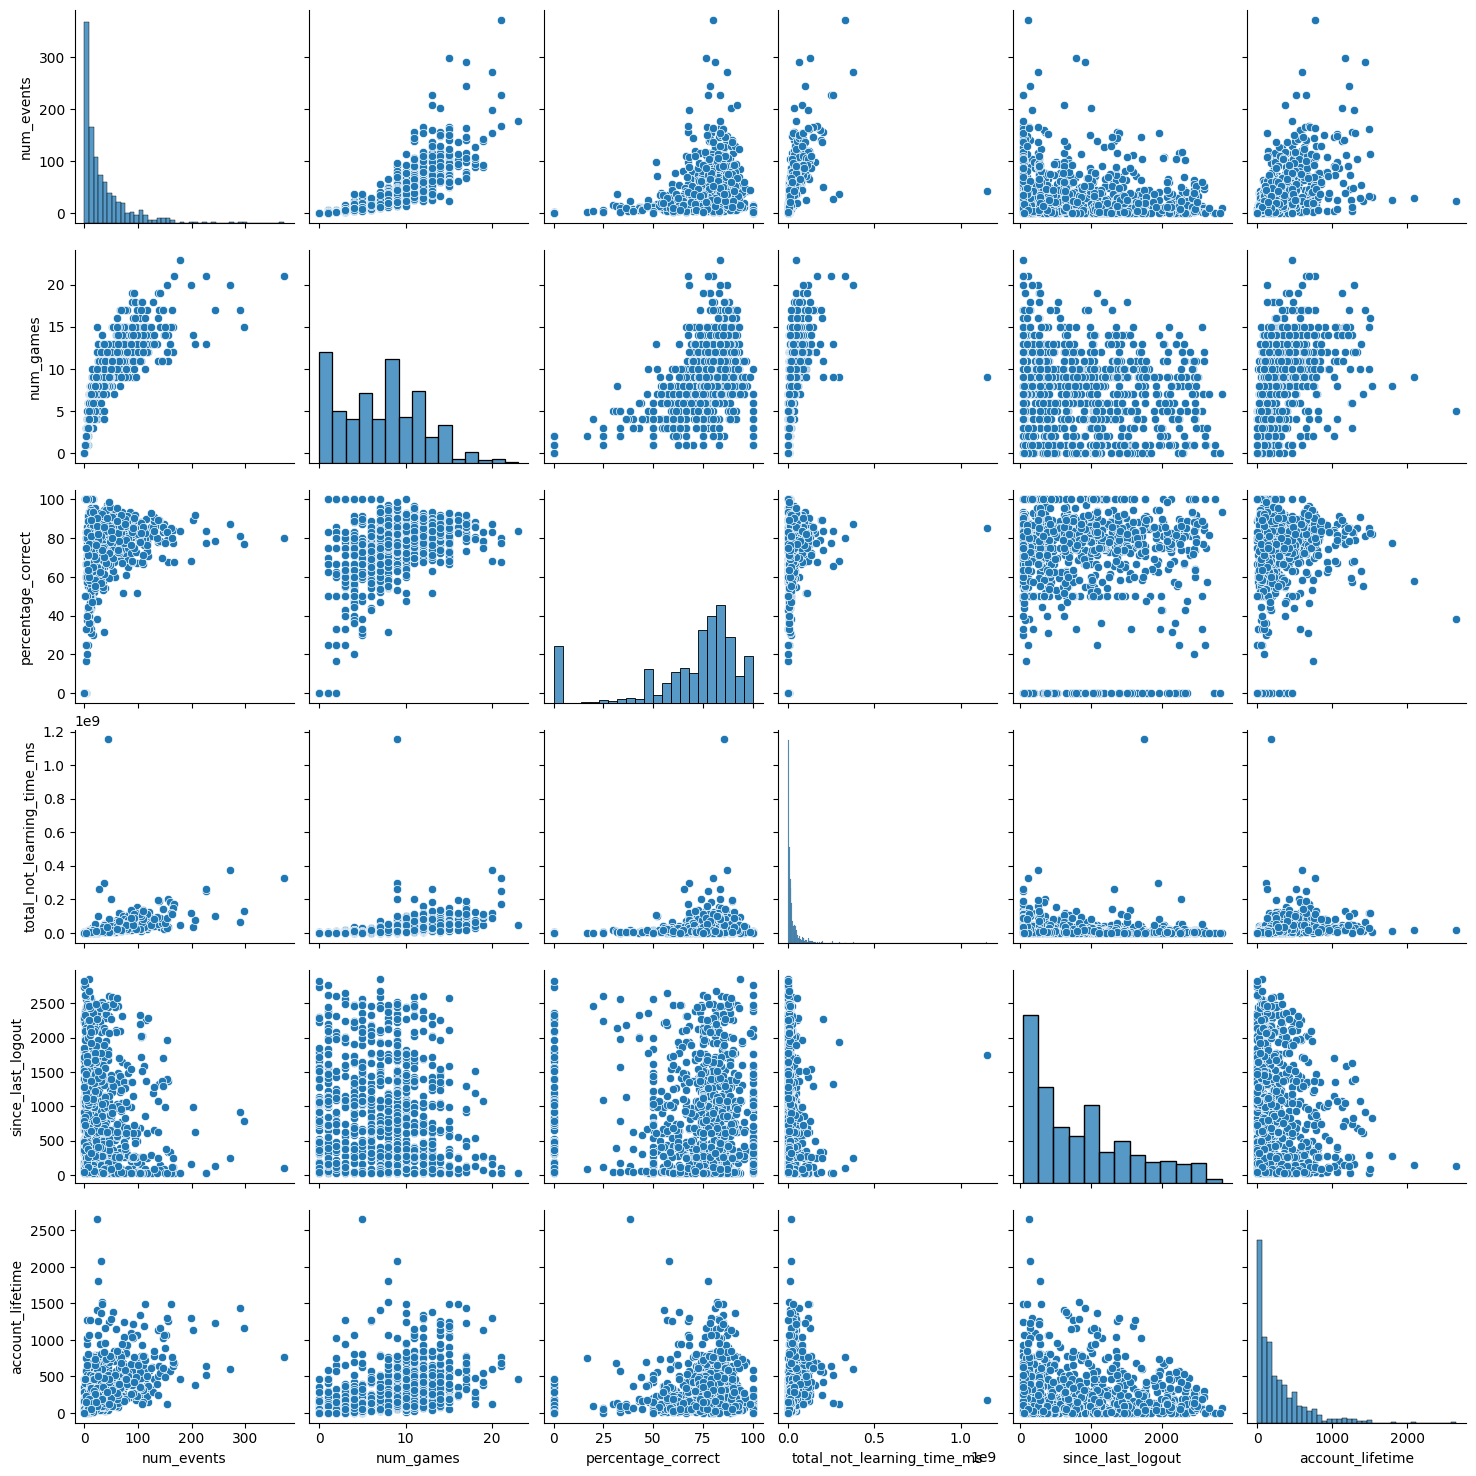

In [185]:
def get_pairplot(df):
    return  sns.pairplot(df)

graphs = get_pairplot(df)
graphs

**Your discussion/interpretation goes here**

**Hypotheses**

1. **First pair: account_lifetime, since_lat_logout**

- The accounts that exists for very short time, are tend to be abandoned. There are users who did not find this app atractive, so after a short time of using never come back.
- The most of the accounts that were using for a long time, have higher changes to have shorter time since last logout. 

2. **Second pair: account_lifetime, percentage_correct**

- The longer accounts exists the rate of answer correctness increases

**Interpretation**

1. **First pair: account_lifetime, since_lat_logout**

We could confirm first hypothesis. Outliers of since last logout with smallest values correspond to smallest values of account lifetime. Altough the second assumption is intuitively consistent with fact, cannot the proven based on these data. So strong relation between variables is questionable.

2. **Second pair: account_lifetime, percentage_correct**

My assumptions seem to be true, but only partially. There is not strong trend that could be observed on the plot of two variables. However they are weakly, possitively correlated which points that there relation between them 

# Task 3: Time-Series Analysis

In the last task, you will perform a time-series analysis.


#### a) Build a data frame containing one row per user per week:

``[user_id, week, num_events, num_questions, percentage_correct, num_shop]``


The features are defined as follows:

- **num_questions**: total number of questions the student answered **per week**.

- **num_events**: total number of events of the student per week.

- **percentage_correct**: number of correct answers/total number of answers  **per week** (hint: answer = correct). If desired, you may assign a weight of 0.5 to partially correct answers.

- **num_shop**: total number of shop events **per week** (where the student wins animals for their zoo with rewards from the games).

Where week 0 is the first week the specific user solved a task in the platform, i.e., the user's earliest entry in the subtasks table.

Hint: You may extract the week of the year (dt.week) from the timestamps. 

You can limit the number of weeks to 13, i.e. for each user we just look at the first 13 weeks of data.
Yoy may change and justify your choice for the number of weeks.

In [186]:
events['start'] = events['start'].astype('datetime64[ns]')
events['end'] = events['end'].astype('datetime64[ns]')
subtasks['subtask_finished_timestamp'] = subtasks['subtask_finished_timestamp'].astype('datetime64[ns]')

In [191]:

# Your code for building the dataframe goes here
limit_num_of_weeks = 13


def assign_weeks(df, time_col):
    df = df.copy()
    correct_ans = 0

    df['week'] = df[f'{time_col}'].dt.isocalendar().week
    first_week = df['week'].min()

    weeks_data = df.groupby(by=['week'])
    if 'correct' in df.columns:
        correct_ans = weeks_data['correct'].sum()
        correct_ans.index -= first_week
    weeks_data = df.groupby(by=['week']).count()
    weeks_data.index -= first_week
    return weeks_data, correct_ans

def create_dataframe_multi_index(df):
    multi_index = [[], []]
    df = pd.DataFrame(columns = ['num_questions','num_events', 'percentage_correct', 'num_shop'], index = multi_index)
    df.index = df.index.set_names(['user_id', 'week'])
    print(df)

    for user_id, user in users.iterrows():
        games = events.loc[events['user_id'] == user_id]

        weeks_data, correct_ans = assign_weeks(games, 'start')

        user_subtasks= subtasks.loc[subtasks['user_id'] == user_id]


        user_subtasks = user_subtasks.dropna(subset = ['subtask_finished_timestamp'])
        answers, how_many_correct = assign_weeks(user_subtasks, 'subtask_finished_timestamp')
        length = len(answers) if len(answers) < len(weeks_data) else len(weeks_data)
        answers = answers[:length]
        weeks_data = weeks_data[:length]

        weeks = weeks_data.index

        user_ids = [user_id for i in range(length)]

        tuples = list(zip(user_ids, weeks))

        index = pd.MultiIndex.from_tuples(tuples, names=['user_id', 'week'])

        how_many_answers = answers['event_id']

        percentage_correct = (how_many_correct / how_many_answers) * 100 if len(how_many_answers) else pd.DataFrame([None for i in range(len(weeks))])
        how_many_answers = how_many_answers if len(how_many_answers) else pd.DataFrame([None for i in range(len(weeks))])

        num_events = weeks_data['start']
        num_shop = weeks_data['type']

        df1 = pd.DataFrame(columns = ['num_questions','num_events', 'percentage_correct', 'num_shop'], index = index)


        if (len(index) > 0):
            num_shop.index = index
            num_events.index = index

            percentage_correct.index = index

            how_many_answers.index = index
            df1['num_events'] = num_events
            df1['num_shop'] = num_shop
            df1['percentage_correct'] = percentage_correct
            df1['num_questions'] = how_many_answers
            df = pd.concat([df, df1], axis=0)
    return df

ts = create_dataframe_multi_index(df)

Empty DataFrame
Columns: [num_questions, num_events, percentage_correct, num_shop]
Index: []


In [188]:
def convert_categorical_to_num(ts):
    ts['num_questions'] = ts['num_questions'].astype('int64')
    ts['num_events'] = ts['num_events'].astype('int64')
    ts['num_shop'] = ts['num_shop'].astype('int64')

convert_categorical_to_num(ts)
ts.dtypes

num_questions           int64
num_events              int64
percentage_correct    float64
num_shop                int64
dtype: object

#### b) Select two features and analyze their behavior over time. Please provide a hypothesis and visualization for both features. For ideas on how to perform a time series exploration, please check the lecture slides and notebook. Discuss your results: what do you observe? Do the results confirm your hypotheses?

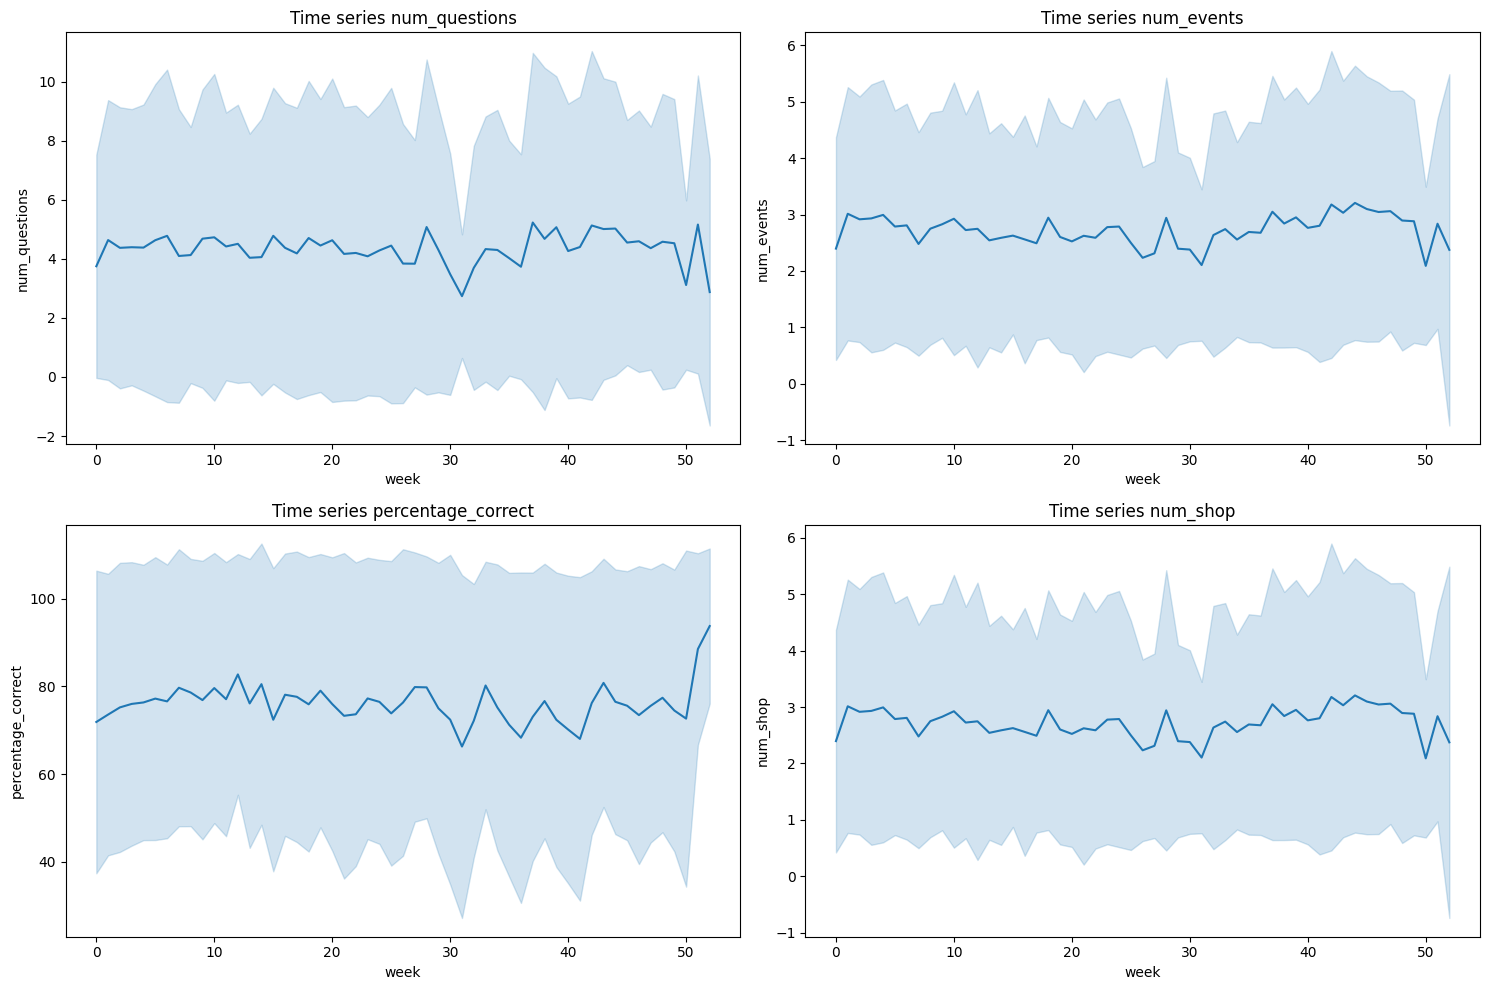

In [189]:
def plot_time_series(df, hue=None):
    
    continuous_cols = list(df._get_numeric_data().columns)
    fig, axes = (plt.subplots(2, np.ceil(len(continuous_cols) /2).astype(int), figsize=(15,5*2)))

    for i, col in enumerate(continuous_cols):
        ax = axes[i //2 , i %2]
        sns.lineplot(data=df, x="week", y=col, ax = ax, errorbar='sd', hue=hue)
        ax.set(xlabel="week", ylabel=col, title= 'Time series {}'.format(col))

    fig.tight_layout()
    plt.show()

plot_time_series(ts)

**Your discussion goes here**

**Hypotheses**
1. **First feature: percentage_correct**
- Correctness increases over the weeks, as users are gathering knowledge.

2. **Second feature: num_question**
- Number of questions that are answered increases, as they are easier for users over the weeks.

**Interpretation**

1. **First feature: percentage_correct**
- It seems to be true, because we can find the rise from around 75% in the first week to above 90% in the last week. However changes are not regular, there are a lot of fluctuations among weeks. 

2. **Second feature: num_question**
- This hypothesis seems to be not true, beacuse number of questions that are answered during the week fluctuates insignificantly, but roughly. It maintains the average number of answered question at level four.


# Task 4: Creative extension 

Please provide **one** new hypothesis you would like to explore with the data and provide a visualization for it. Discuss your results: what do you observe? Do the results confirm your hypotheses?



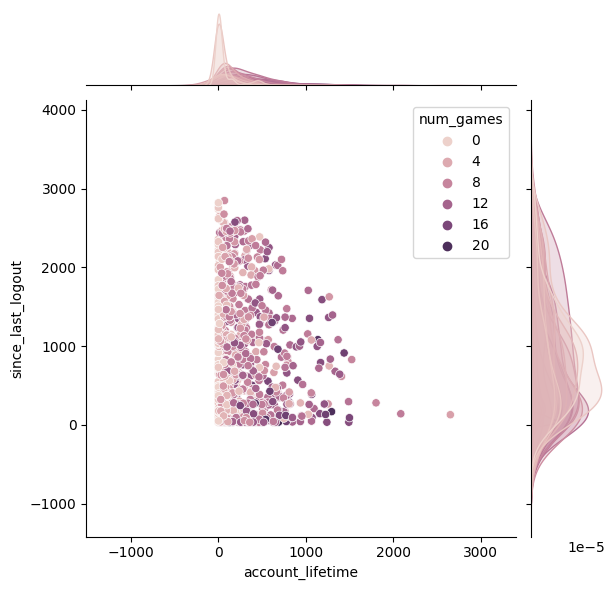

In [190]:
# Your creative visualization here

#Visualization for dataframe from task2:
df = create_dataframe()
df = add_features(df)
convert_time_to_num(df)

def var_joinplot(df, y, x, hue):
    sns.jointplot(data = df, y = y, x = x, hue = hue)

var_joinplot(df, 'since_last_logout', 'account_lifetime', 'num_games')

**Interpretation goes here**

**Hypothesis**
- As account lifetime increasing the time from last logout decreases. We can observe that number of games increase as account lifetime increases. 

**Interpretation**

The chart shows interdependence between account lifetime and number of games, however the relationship between number of games and time since last logout seem not to be strong (inversly dependent). Our observations are proven by the heatmap, where we can read the correlation between these variables. 